In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

/home/wajeeh-ros/.conda/envs/python3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wajeeh-ros/.conda/envs/python3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wajeeh-ros/.conda/envs/python3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wajeeh-ros/.conda/envs/python3/lib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
#tfds.list_builders()

In [6]:
splits = tfds.Split.TRAIN.subsplit([70, 30])

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the TensorFlow Datasets documentation you will see that the name of the Flowers dataset is tf_flowers. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use tfds.splits to split this training set into to a training_set and a validation_set. Do a [70, 30] split such that 70 corresponds to the training_set and 30 to the validation_set. Then load the tf_flowers dataset using tfds.load. Make sure the tfds.load function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.

In [7]:
#splits = tfds.Split.ALL.subsplit(weighted=(70,30))

#(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, split=splits)



In [8]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



In [9]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1,
                                   example[0].shape, example[1]))

Image 1 shape: (240, 223, 3) label: 4
Image 2 shape: (333, 500, 3) label: 2
Image 3 shape: (240, 320, 3) label: 2
Image 4 shape: (213, 320, 3) label: 4
Image 5 shape: (240, 320, 3) label: 0


In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an image and a label as arguments and should return the new image and corresponding label. Then create training and validation batches of size 32.

In [10]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In the cell below create a feature_extractor using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the TensorFlow Hub documentation to see a list of available feature vectors. Click on the tf2-preview/mobilenet_v2/feature_vector. Read the documentation and get the corresponding URL to get the MobileNet v2 feature vector. Finally, create a feature_extractor by using hub.KerasLayer with the correct input_shape parameter.

In [11]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [12]:
feature_extractor.trainable=False

In the cell below create a tf.keras.Sequential model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [13]:
model = tf.keras.models.Sequential([
    feature_extractor,
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


##### train the model
In the cell bellow train this model like any other, by first calling compile and then followed by fit. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.


In [14]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 44s 544ms/step - loss: 0.8128 - accuracy: 0.6992 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 48s 597ms/step - loss: 0.3825 - accuracy: 0.8784 - val_loss: 0.3727 - val_accuracy: 0.8722
Epoch 3/6
81/81 [==============================] - 42s 516ms/step - loss: 0.2950 - accuracy: 0.9062 - val_loss: 0.3377 - val_accuracy: 0.8843
Epoch 4/6
81/81 [==============================] - 42s 519ms/step - loss: 0.2436 - accuracy: 0.9208 - val_loss: 0.3196 - val_accuracy: 0.8917
Epoch 5/6
81/81 [==============================] - 40s 488ms/step - loss: 0.2072 - accuracy: 0.9320 - val_loss: 0.3087 - val_accuracy: 0.8907
Epoch 6/6
81/81 [==============================] - 39s 483ms/step - loss: 0.1796 - accuracy: 0.9502 - val_loss: 0.3014 - val_accuracy: 0.8926


In the cell below, plot the training and validation accuracy/loss graphs.

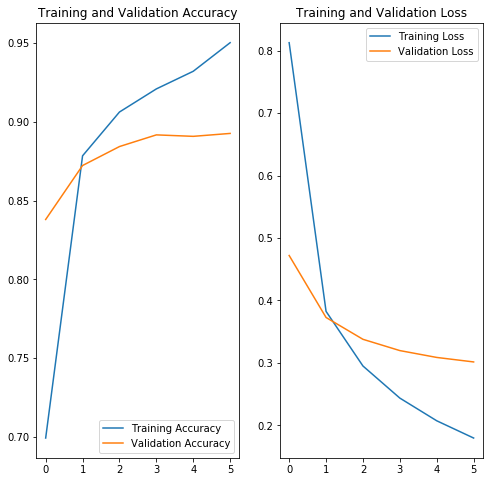

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()




In [16]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)


['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


create an image batch and make prediction

In [17]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['dandelion' 'roses' 'dandelion' 'daisy' 'sunflowers' 'roses' 'dandelion'
 'sunflowers' 'dandelion' 'dandelion' 'sunflowers' 'dandelion' 'roses'
 'sunflowers' 'dandelion' 'dandelion' 'tulips' 'tulips' 'daisy'
 'sunflowers' 'sunflowers' 'roses' 'tulips' 'roses' 'roses' 'dandelion'
 'tulips' 'roses' 'tulips' 'roses' 'sunflowers' 'dandelion']


In [18]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 4 3 1 3 4 0 3 0 0 3 0 4 3 0 0 2 2 1 3 3 4 2 4 4 0 2 4 2 4 3 0]
Predicted labels:  [0 4 0 1 3 4 0 3 0 0 3 0 4 3 0 0 2 2 1 3 3 4 2 4 4 0 2 4 2 4 3 0]


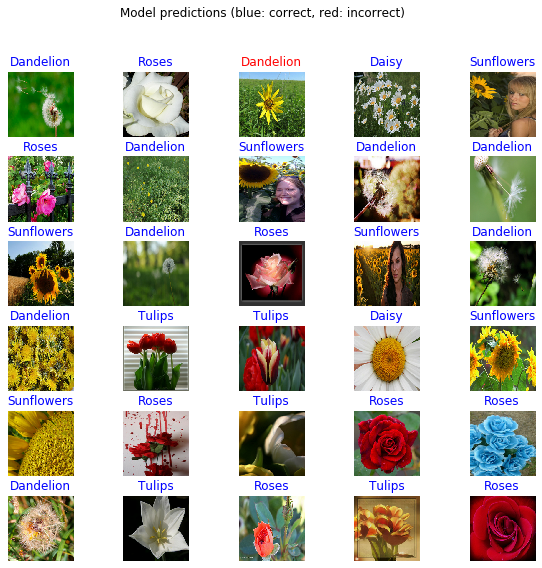

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# TODO: Perform Transfer Learning with the Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [24]:
IMAGE_RES=299

(training_set, validation_set), dataset_info = tfds.load('tf_flowers',
                                                         with_info=True,
                                                        as_supervised=True,
                                                        split=splits)

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL_Inception = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL_Inception,
                                   trainable=False, 
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

model_inception = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
model_inception.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS=6

history = model_inception.fit(train_batches,epochs=EPOCHS,
                             validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 141s 2s/step - loss: 0.7268 - accuracy: 0.7452 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
81/81 [==============================] - 137s 2s/step - loss: 0.3813 - accuracy: 0.8799 - val_loss: 0.3748 - val_accuracy: 0.8806
Epoch 3/6
81/81 [==============================] - 137s 2s/step - loss: 0.3030 - accuracy: 0.9112 - val_loss: 0.3364 - val_accuracy: 0.8944
Epoch 4/6
81/81 [==============================] - 135s 2s/step - loss: 0.2575 - accuracy: 0.9228 - val_loss: 0.3160 - val_accuracy: 0.8972
Epoch 5/6
81/81 [==============================] - 136s 2s/step - loss: 0.2254 - accuracy: 0.9328 - val_loss: 0.3038 - val_accuracy: 0.8981
Epoch 6/6
81/81 [==============================] - 135s 2s/step - loss: 0.2006 - accuracy: 0.9413 - val_loss: 0.2955 - val_accuracy: 0.9000
